In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sqlalchemy import create_engine
import calendar
sns.set_style("darkgrid")
sns.set(font_scale=1.5)

%matplotlib inline

In [107]:
def get_flights_per_month():
    """ Returns a Dataframe for flights by Month  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        flights = pd.read_sql("""
            SELECT 
                f.year as year,
                f.month as month,
                1 as day,
                count(f.flights) AS departures,
                SUM(f.departure_was_delayed_15) AS departure_delays,
                sum(f.diverted) as diverted,
                sum(f.cancelled) as cancelled
            FROM 
                flights AS f
            WHERE 
                f.year IN (2017, 2016, 2015, 2014, 2013)
            GROUP BY 
                f.year, f.month, day
            ORDER BY
                f.year, f.month, day
        """, conn)
    flights['fraction_delayed'] = flights['departure_delays'] / flights['departures']
    flights['month_abbr'] = flights['month'].apply(lambda x: calendar.month_abbr[x])
    return flights.set_index(pd.to_datetime(flights[['year', 'month', 'day']])).sort_index()

flights = get_flights_per_month()
flights.head()

,year,month,day,departures,departure_delays,diverted,cancelled,fraction_delayed,month_abbr
2013-01-01,2013,1,1,509519,83200,1131,7561,0.163291,Jan
2013-02-01,2013,2,1,469746,78285,857,11329,0.166654,Feb
2013-03-01,2013,3,1,552312,98954,962,8933,0.179163,Mar
2013-04-01,2013,4,1,536393,105215,1009,9459,0.196153,Apr
2013-05-01,2013,5,1,548642,101633,1420,6238,0.185245,May


# How many flights are included in the data for FY2016?

In [108]:
FY2016 = flights['2015-10-01':'2016-09-30']

departures_FY2016 = FY2016['departures'].sum()
delays_FY2016 = FY2016['departure_delays'].sum()
rate_of_delay = delays_FY2016 / departures_FY2016

print("Total Domestic Departures (FY2016): ", "{:,}".format(departures_FY2016))
print("Total Delayed Departures (FY2016):  ", "{:,}".format(delays_FY2016))
print("Percent of Flights Delayed (FY2016): ", '{:5.2f}%'.format(rate_of_delay * 100))

Total Domestic Departures (FY2016):  5,666,512
Total Delayed Departures (FY2016):   957,836
Percent of Flights Delayed (FY2016):  16.90%


## Which months experience the greatest flight volumes?

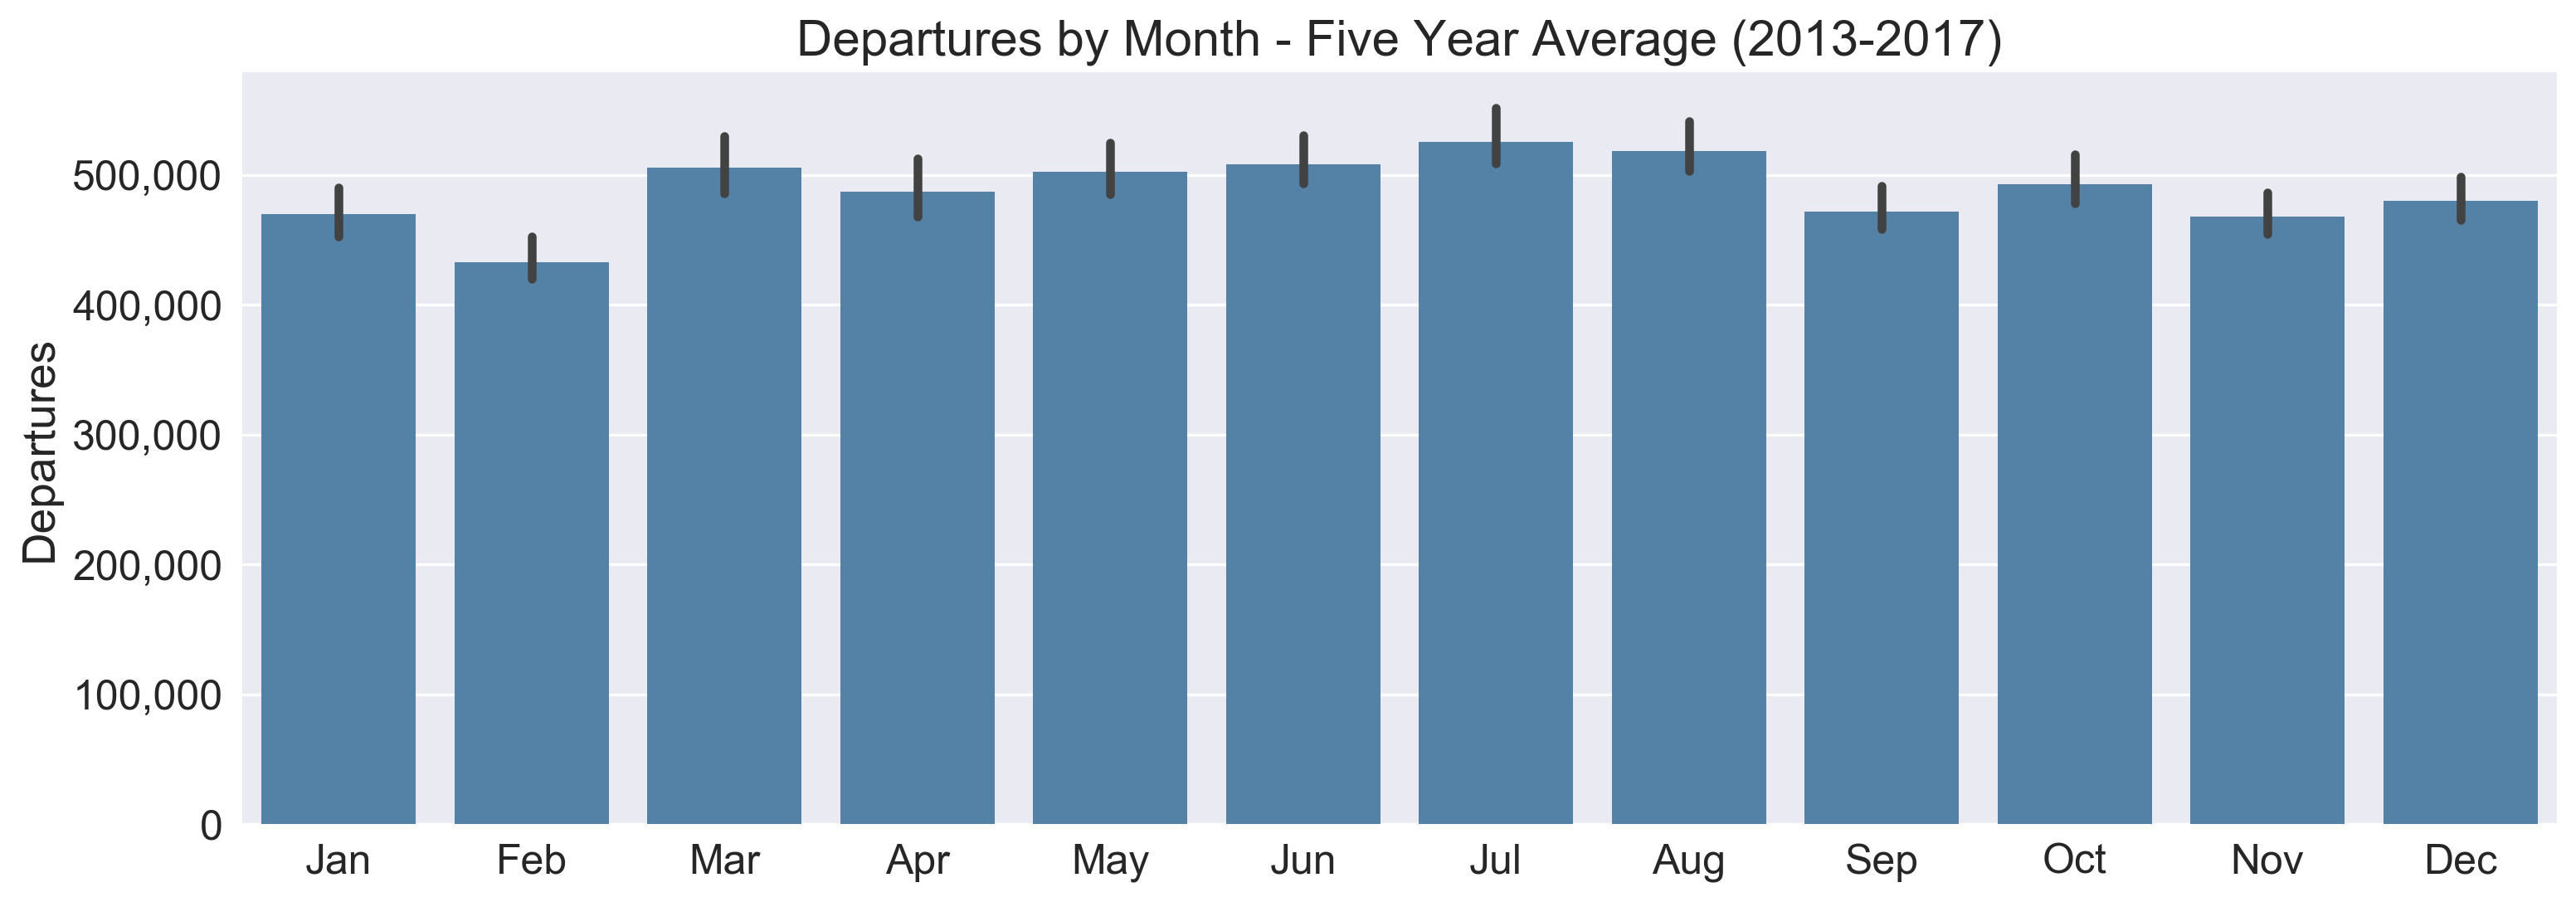

In [119]:
def plot_monthly_average_departures(flights):
    ax, fig = plt.subplots(figsize=(15, 5), dpi=240)
    color = sns.color_palette("binary_r", 1)

    plt.title('Departures by Month - Five Year Average (2013-2017)')
    # Let seaborn do the averages
    ax = sns.barplot(x='month_abbr', y='departures', data=flights, color="steelblue")
    
    # Add , to flight counts
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.xlabel('')
    plt.ylabel('Departures')
    plt.savefig("../../reports/figures/departures-by-month.png", bbox_inches='tight')
    plt.show()
    
plot_monthly_average_departures(flights)

## Which months experience the greatest rates of delay?

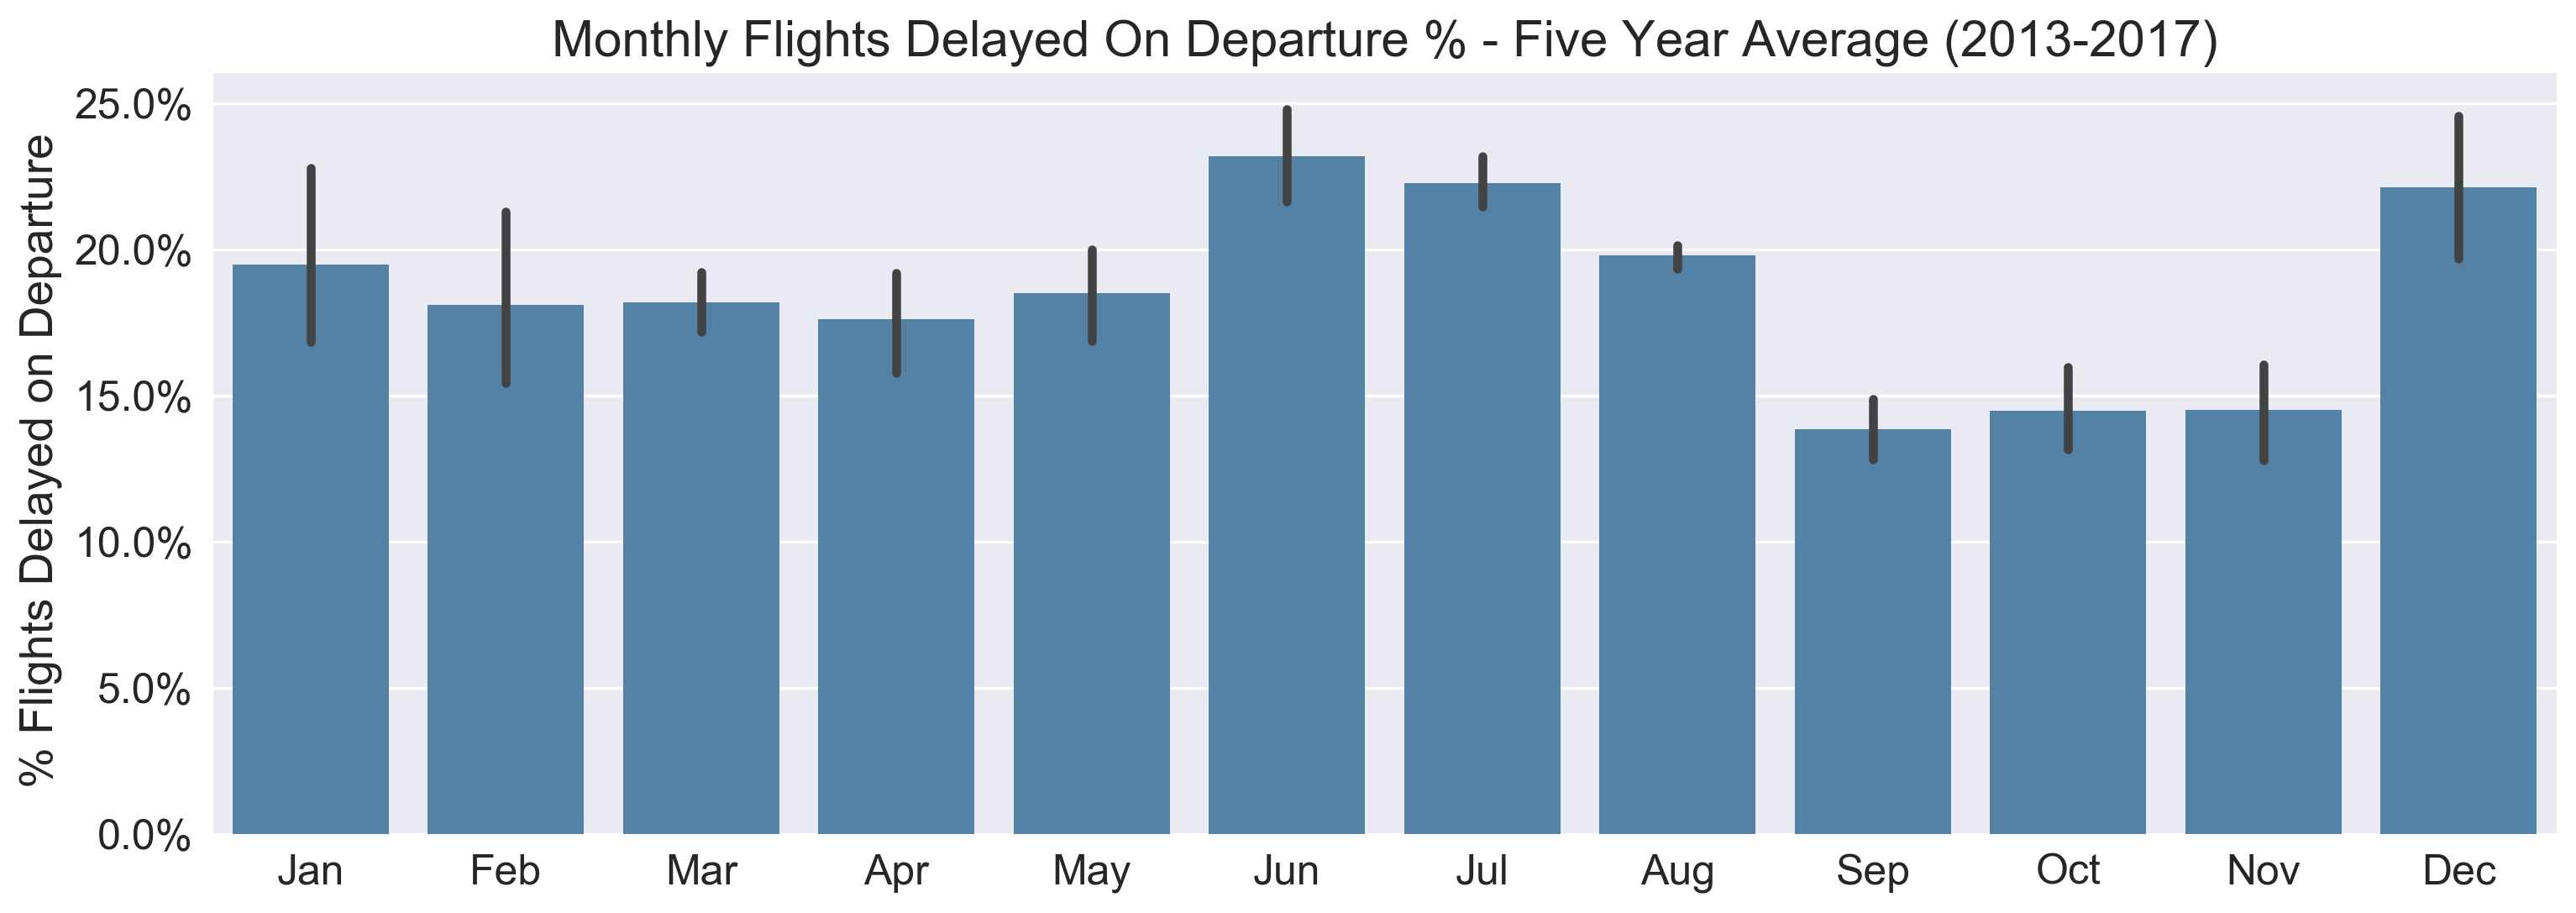

In [120]:
def plot_monthly_average_rate_of_departure_delays(flights):
    ax, fig = plt.subplots(figsize=(15, 5), dpi=240)
    color = sns.color_palette("binary_r", 1)

    plt.title('Monthly Flights Delayed On Departure % - Five Year Average (2013-2017)')
    # Let seaborn do the averages
    ax = sns.barplot(x='month_abbr', y='fraction_delayed', data=flights, color="steelblue")
    
    # Add , to flight counts
    ax.get_yaxis().set_major_formatter(PercentFormatter(xmax=1))

    plt.xlabel('')
    plt.ylabel('% Flights Delayed on Departure ')
    plt.savefig("../../reports/figures/rates-of-delay-per-month.png", bbox_inches='tight')
    plt.show()
    
plot_monthly_average_rate_of_departure_delays(flights)